In [1]:
import sys

sys.path.append("../functions")

from Utils import *
from Plotting import *
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# from sklearn.linear_model import LinearRegression
# import seaborn as sns
import warnings
import seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.special import logsumexp
from itertools import product
from functools import partial
from multiprocessing import Pool


In [2]:
import random
import numpy as np

seed = 12
random.seed(seed)
np.random.seed(seed)


In [3]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cj","cor", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [4]:
## def logll
def get_states_prob_hsmm(dist_params, log_emmission_prob_seq, T, durations):
    
    D = len(durations)
    
    dist = scipy.stats.nbinom(*dist_params)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])

    state_k_prob = np.zeros((T,2, D))

    for t, time in enumerate(range(1,T+1)):
        temp_d = np.zeros((2,D))
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
                d_emmission_prob = log_emmission_prob_seq[t,:, k]
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
                d_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
                d_emmission_prob = log_emmission_prob_seq[t,:,k]

            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            temp_d[:,k] = d_emmission_prob + transition_log[k] + np.flip(log_alpha[time-current_time,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

    state_log_probs = logsumexp(state_k_prob, axis = -1)
    sum_probs = logsumexp(state_log_probs, axis=1, keepdims=True)
    state_log_probs = state_log_probs - sum_probs
    state_probs = np.exp(state_log_probs)
    return state_probs

def sub_state_prob_hsmm(sub_id):
  
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    T = len(sub_data)
    rewards = sub_data["reward"].to_numpy()*100
    actions = sub_data["resp"].to_numpy()

    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)

    log_emmision_prob[:,0] = low_reward_dist.logpdf(rewards) # low_reward
    log_emmision_prob[:,1] = high_reward_dist.logpdf(rewards) # high_reward


    durations = range(1,71)
    D = len(durations)


    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    for t, time in enumerate(range(1,T+1)):
            for d, duration in enumerate(durations):
                if t-d < 0:
                    log_emmission_prob_seq[t,:,d] = -np.inf
                else:
                    log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                    np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])

                    log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                        np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])
    
    p_range = np.linspace(0.01, 0.99, 16)  
    n_range = np.arange(1, 100, 16)
    grid = list(product(n_range, p_range))
    
    func = partial(get_states_prob_hsmm, log_emmission_prob_seq= log_emmission_prob_seq, T = T, durations = durations)

    with Pool(128) as pool:
        results = pool.map(func, grid)

    return grid,results

In [5]:
def protected_log(x):
    return np.log((1e-200 / 2) + (1 - 1e-200) * x)

def calculate_mf_probs(params, resps, rewards):
    alpha, beta = params[:2]
    Q = np.array([0.5, 0.5])
    probabilities = np.zeros(len(resps))
    for t, (resp, reward) in enumerate(zip(resps, rewards)):
        choice_prob = softmax_func(Q, beta)
        probabilities[t] = choice_prob[resp]
        Q[resp] += alpha * (reward - Q[resp])
    return probabilities



def ll_mix_model(params, resps, rewards, mb_probs):
    gamma, alpha, beta = params
    
    mf_probs = calculate_mf_probs((alpha,beta), resps, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
    
    return -np.sum(protected_log(mix_probs))


def fit_n_times(n_fitting, params_ranges, func, func_args):
    results = [minimize(func, x0=[np.random.uniform(*r) for r in params_ranges], args=func_args, bounds=params_ranges) for _ in range(n_fitting)]
    best_result = min(results, key=lambda x: x.fun if x.success else np.inf)
    return best_result.x, best_result.fun



def process_fit(args):
    i, results, actions, rewards, T = args
    states_prob_hsmm = results[i]
    mb_probs = states_prob_hsmm[np.arange(T), actions]
    x, ll = fit_n_times(20, params_ranges=[[0,1],[0.01, 1], [0.01, 100]],
                         func=ll_mix_model, func_args=(actions, rewards, mb_probs))
    return ll, x

def get_ll_model(sub_id): 
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    T = len(actions)
    grid, results = sub_state_prob_hsmm(sub_id)
    
    args_list = [(i, results, actions, rewards, T) for i in range(len(results))]
    
    with Pool(60) as pool:
        results_parallel = pool.map(process_fit, args_list)
    
    neg_ll_seq, params = zip(*results_parallel)
    
    min_idx = np.argmin(neg_ll_seq)
    neg_ll = neg_ll_seq[min_idx]
    mf_x = params[min_idx]
    mb_x = grid[min_idx]
    
    return neg_ll, mf_x, mb_x


In [6]:
def conf_dist(params, resps, rewards, confs, mb_probs):
    gamma, alpha, beta, lbound, bound_range = params
    hbound = bound_range * (5 - lbound) + lbound

    mf_probs = calculate_mf_probs((alpha,beta), resps, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
    model_confs = linear_transform_on_array(mix_probs, [0, 1], [lbound, hbound])
    dist = mean_square_distance(confs, model_confs)
    
    return dist

def process_fit_backward(args):
    i, results, actions, rewards, confs, T = args
    states_prob_hsmm = results[i]
    mb_probs = states_prob_hsmm[np.arange(T), actions]
    x, ll = fit_n_times(60, params_ranges=[[0,1],[0.01, 1], [0.01, 100], [1, 5], [0, 1]],
                         func=conf_dist, func_args=(actions, rewards, confs, mb_probs))
    return ll, x

def get_dist_model(sub_id): 
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    confs = sub_data["cj"].to_numpy()
    
    T = len(actions)
    grid, results = sub_state_prob_hsmm(sub_id)
    
    args_list = [(i, results, actions, rewards, confs, T) for i in range(len(results))]
    
    with Pool(60) as pool:
        results_parallel = pool.map(process_fit_backward, args_list)
    
    dist_seq, params = zip(*results_parallel)
    
    min_idx = np.argmin(dist_seq)
    min_dist = dist_seq[min_idx]
    mf_x = params[min_idx]
    mb_x = grid[min_idx]
    
    return min_dist, mf_x, mb_x


In [7]:
# Assuming `subjects` is defined somewhere in your code
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    min_dist, mf_x, mb_x = get_dist_model(sub_id)
    gamma, alpha, beta, lbound, bound_range = mf_x
    n, p = mb_x
    
    results.append({
        "subject": subject,
        "Confidence Distance": min_dist,
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p,
        "lbound": lbound,
        "bound_range": bound_range,
        "hbound": (5 - lbound) * bound_range + lbound
        
    })

df = pd.DataFrame(results)


0


Process ForkPoolWorker-174:
Process ForkPoolWorker-160:
Process ForkPoolWorker-166:
Process ForkPoolWorker-175:
Process ForkPoolWorker-164:
Process ForkPoolWorker-176:
Process ForkPoolWorker-144:
Process ForkPoolWorker-170:
Process ForkPoolWorker-188:
Process ForkPoolWorker-137:
Process ForkPoolWorker-148:
Process ForkPoolWorker-141:
Process ForkPoolWorker-149:
Process ForkPoolWorker-172:
Process ForkPoolWorker-153:
Process ForkPoolWorker-169:
Process ForkPoolWorker-186:
Process ForkPoolWorker-162:


KeyboardInterrupt: 

Statistics for fwd and back =453.0, p=1.268e-02
mean fwd = 0.65
mean back = 0.57


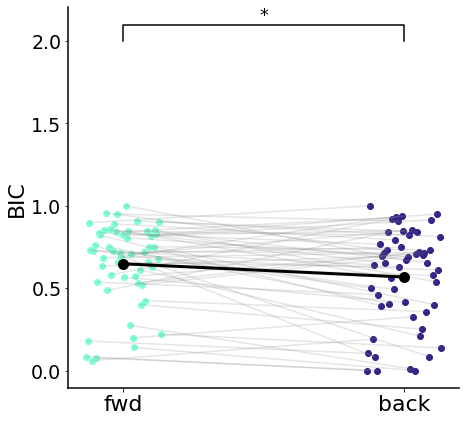

In [72]:

groups = ["fwd", "back"]
fwd_df = pd.read_csv("../results/forward_mix_df.csv")
merged_df = merge_result_df([fwd_df, df], groups, 200, subjects)



color_dict = {"fwd": "#7FFFD4", "back": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
comparison_plot(
    merged_df,
    "gamma",
    groups,
    "",
    [["fwd", "back"]],
    [2, 1000, 1100],
    [.1, 20, 20],
    y_label="BIC",
    color_dict = color_dict
)

Statistics for mf and mix =4.0, p=2.035e-10
mean mf = 0.74
mean mix = 0.68


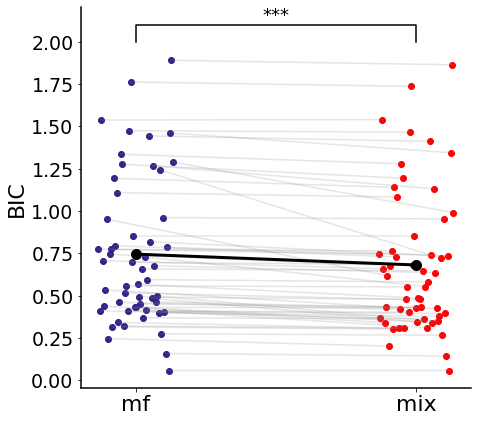

In [65]:

groups = ["mf", "mix"]
merged_df = merge_result_df([backward_df, df], groups, 200, subjects)



color_dict = {"mb": "#7FFFD4", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
comparison_plot(
    merged_df,
    "Confidence Distance",
    groups,
    "",
    [["mf", "mix"]],
    [2, 1000, 1100],
    [.1, 20, 20],
    y_label="BIC",
    color_dict = color_dict
)

In [62]:
df.to_csv("../results/backward_mix_df.csv", index=False)



In [56]:
pd.read_csv("../results/backward_df.csv")


,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound
0,0,45628,1.000000,13.260773,4.606822,0.221283,139.034742,0.774456,4.693826
1,1,45640,0.003908,100.000000,3.968332,1.000000,275.681213,0.410537,5.000000
2,2,45664,0.001108,100.000000,1.270128,1.000000,275.198521,1.536389,5.000000
3,3,45682,0.658565,57.058489,2.026064,0.693936,453.481327,0.705934,4.089785
4,4,45745,1.000000,7.876813,4.041896,1.000000,190.566015,0.437457,5.000000
5,5,45760,0.747970,23.764481,1.000000,0.927304,82.892275,0.533329,4.709216
6,6,45763,0.900032,11.528013,2.346941,0.937333,69.632268,0.950495,4.833740
7,7,45805,0.945863,5.261965,4.643275,1.000000,212.436669,0.245864,5.000000
8,8,45829,1.000000,14.589953,1.331203,0.832861,112.315230,0.742902,4.386802
9,9,45964,0.486703,29.946130,1.794287,0.765650,164.947424,0.772505,4.248742


In [257]:
mf_df = pd.read_csv("../results/forward_df.csv")
mb_df = pd.read_csv("../results/")

array([  0.17916891,   0.69830555, 100.        ])

In [127]:
res[np.arange(T), actions].shape

NameError: name 'T' is not defined

In [128]:
mb_res = []
T = 400
for sub_id, subject in enumerate(subjects):
    print("sub_id", sub_id)
    grid, results = sub_state_prob_hsmm(sub_id)
    
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    
    neg_ll_seq = []
    for res in results:
        probs = res[np.arange(T), actions]
        neg_ll_seq.append(-np.sum(protected_log(probs)))
    
    min_idx = np.argmin(neg_ll_seq)
    
    neg_ll = neg_ll_seq[min_idx]
    mb_x = grid[min_idx]

    n, p = mb_x
    
    mb_res.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "n": n,
        "p": p
    })

mb_df = pd.DataFrame(mb_res)



sub_id 0
sub_id 1
sub_id 2
sub_id 3
sub_id 4
sub_id 5
sub_id 6
sub_id 7
sub_id 8
sub_id 9
sub_id 10
sub_id 11
sub_id 12
sub_id 13
sub_id 14
sub_id 15
sub_id 16
sub_id 17
sub_id 18
sub_id 19
sub_id 20
sub_id 21
sub_id 22
sub_id 23
sub_id 24
sub_id 25
sub_id 26
sub_id 27
sub_id 28
sub_id 29
sub_id 30
sub_id 31
sub_id 32
sub_id 33
sub_id 34
sub_id 35
sub_id 36
sub_id 37
sub_id 38
sub_id 39
sub_id 40
sub_id 41
sub_id 42
sub_id 43
sub_id 44
sub_id 45
sub_id 46
sub_id 47
sub_id 48
sub_id 49
sub_id 50
sub_id 51
sub_id 52
sub_id 53


In [133]:
mb_df.to_csv("../results/mb_forward_2.csv", index=False)

Statistics for mf and mb =260.0, p=3.261e-05
Statistics for mb and mix =5.0, p=2.153e-10
Statistics for mf and mix =700.0, p=7.144e-01
mean mf = 232.22
mean mb = 303.42
mean mix = 213.22


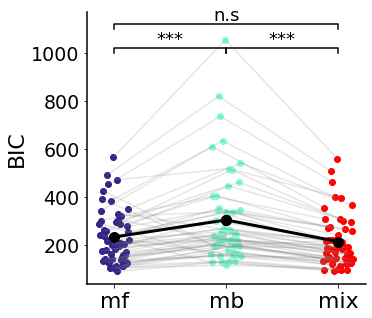

In [87]:
from Utils import *
from Plotting import *

mf_df = pd.read_csv("../results/forward_df.csv")
mf_df["bic"] = 2*mf_df["LL"] + 2*np.log(400)
mb_df = pd.read_csv("../results/mb_forward_2.csv")
mb_df["bic"] = 2*mb_df["neg_ll"] + 2*np.log(400)
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")
mix_df["bic"] = 2*mix_df["neg_ll"] + 5*np.log(400)

groups = ["mf", "mb", "mix"]
merged_df = merge_result_df([mf_df, mb_df, mix_df], groups, 200, subjects)



color_dict = {"mb": "#7FFFD4", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(5,5))
comparison_plot(
    merged_df,
    "bic",
    groups,
    "",
    [["mf", "mb"], ["mb", "mix"], ["mf", "mix"]],
    [1000, 1000, 1100],
    [20, 20, 20],
    y_label="BIC",
    color_dict = color_dict
)

In [252]:
np.log(400)

5.991464547107982

Statistics for mf and mix =0.0, p=1.626e-10
mean mf = 110.12
mean mix = 91.63


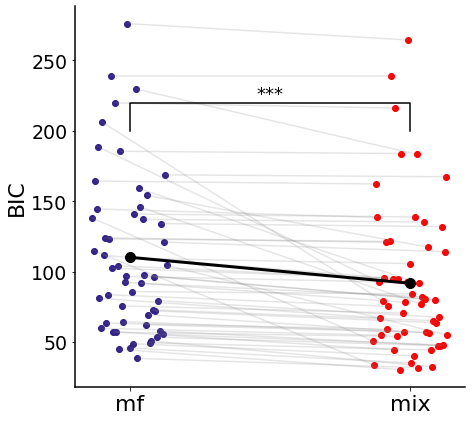

In [251]:
from Utils import *
from Plotting import *

mf_df = pd.read_csv("../results/forward_df.csv")
mf_df["bic"] = 2*mf_df["LL"] + 2*np.log(400)
mf_df["neg_ll"] = mf_df["LL"]
# mb_df = pd.read_csv("../results/mb_forward_2.csv")
# mb_df["bic"] = 2*mb_df["neg_ll"] + 2*np.log(400)
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")
mix_df["bic"] = 2*mix_df["neg_ll"] + 5*np.log(400)

groups = ["mf", "mix"]
merged_df = merge_result_df([mf_df, mix_df], groups, 200, subjects)
# merged_df = merged_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
# merged_df = merged_df[merged_df["best_model"] == "mf"]



color_dict = {"mb": "#7FFFD4", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
comparison_plot(
    merged_df,
    "neg_ll",
    groups,
    "",
    [["mf", "mix"]],
    [200, 600, 600],
    [20, 20, 20],
    y_label="BIC",
    color_dict = color_dict
)

In [86]:
df_best_model = merged_df.loc[merged_df.groupby('subject')['aic'].idxmin()]
# Count the occurrences of each model
plt.figure(figsize=(7, 5))
sns.countplot(data=df_best_model, x="model", palette="viridis")

# Labels and title
plt.xlabel("Model")
plt.ylabel("Count")
plt.title("Frequency of Best Models")

# Show the plot
plt.show()

KeyError: 'Column not found: aic'

In [88]:
plt.Figure(figsize=(10,10))
mix_df_modified = mix_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
# mix_df_modified = mix_df_modified[mix_df_modified["best_model"] == "mf"]

sns.histplot(mix_df_modified, x="gamma", hue="best_model", bins=10)


NameError: name 'df_best_model' is not defined

In [77]:
def simulate_mix_model(sub_data, params):
    
    alph,beta, gamma, n,p = params
    
    lrewards =  sub_data["Lreward"].to_numpy()
    hrewards = sub_data["Hreward"].to_numpy()
    cresps = sub_data["cresp"].to_numpy()
    
    
    T = len(cresps)
    
    # mf
    Q = np.array([0.5, 0.5])
    Q_list = np.zeros((T, 2))
    rewards = np.zeros(T)
    actions = np.zeros(T)
    chosen_probs = np.zeros(T)
    
    #mb
    durations = range(1,71)
    D = len(durations)
    
    dist = scipy.stats.nbinom(n,p)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])
    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)
    state_k_prob = np.zeros((T,2, D))
    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    

    acc = np.zeros(T)
    
    for t,time in enumerate(range(1,T+1)):
        #mf
        low_reward = lrewards[t]
        high_reward = hrewards[t]
        
        mf_probs = softmax_func(Q, beta) #mf prob
        
        #mb
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            
        current_log_state = logsumexp(state_k_prob[t], axis = -1)
        current_log_state -= logsumexp(current_log_state, axis=-1)
        mb_probs = np.exp(current_log_state)
        
        # action 
        mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
        resp = np.random.choice([0, 1], p=mix_probs)        
        
        if resp == cresps[t]:
            reward = hrewards[t]
            acc[t] = 1
        else:
            acc[t] = 0
            reward = lrewards[t]
        actions[t]= resp
        rewards[t]= reward
        
        #mf update
        prediction_error = reward/100 - Q[resp]
        Q[resp] = Q[resp] + alpha * prediction_error
        
        #mb update
        log_emmision_prob[t,0] = low_reward_dist.logpdf(reward)
        log_emmision_prob[t,1] = high_reward_dist.logpdf(reward)

        temp_d = np.zeros((2,D))
        for d, duration in enumerate(durations):
            if time - duration <0 :
                log_emmission_prob_seq[t,:,d] = -np.inf
                d_emmission_prob = -np.inf
            else:
                log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])
                log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                    np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])

                d_emmission_prob = log_emmission_prob_seq[t,:,d]
            temp_d[:,d] = d_emmission_prob + transition_log[d] + np.flip(log_alpha[time-duration,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

#     confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return acc

    
    
    

In [138]:
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")


In [79]:
sub_id = 6
sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
params = mix_df[mix_df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p"]]
acc = simulate_mix_model(sub_data, params)

In [84]:
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")

def run_simulation(sub_id):
    """Function to run 100 simulations and compute the average ACC."""
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    params = mix_df[mix_df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p"]]
    
    acc_values = [np.mean(simulate_mix_model(sub_data, params)) for _ in range(100)]
    avg_acc = np.mean(acc_values)
    
    return subjects[sub_id], avg_acc

num_subjects = len(subjects)  # Assuming subjects is a list

with Pool(processes=60) as pool:
    results = pool.map(run_simulation, range(num_subjects))

# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Subject", "performance"])

results_df.to_csv("../results/mix_simulation_df.csv", index=False)

KeyboardInterrupt: 

In [104]:
forward_sim = pd.read_csv("../results/forward_simulation_df.csv")

In [81]:
forward_sim

NameError: name 'forward_sim' is not defined

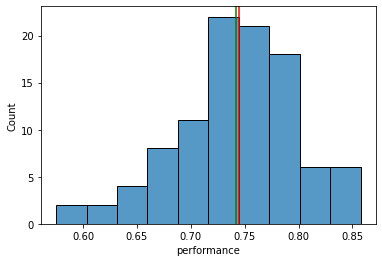

In [247]:
run = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})
run = run[run["subject"] == 46792]
median = run["performance"].median()
mean = run["performance"].mean()
ax = sns.histplot(run, x="performance")
ax.axvline(median, label="medain", c = "red")
ax.axvline(mean, label="medain", c = "green")


In [248]:
forward_sim

,Unnamed: 0,subject,run,resp,reward,cor,cj,Q1,Q2
0,0,45628,0,0,0.625872,1.0,4.650588,0.500000,0.500000
1,1,45628,0,0,0.531705,1.0,4.678600,0.625872,0.500000
2,2,45628,0,1,0.395744,0.0,4.642412,0.531705,0.500000
3,3,45628,0,0,0.657494,1.0,4.680150,0.531705,0.395744
4,4,45628,0,0,0.750121,1.0,4.691411,0.657494,0.395744
...,...,...,...,...,...,...,...,...,...
2159995,2159995,47743,99,1,0.727834,1.0,4.598782,0.228024,0.499049
2159996,2159996,47743,99,1,0.584612,1.0,4.613190,0.228024,0.727834
2159997,2159997,47743,99,1,0.590103,1.0,4.610013,0.228024,0.584612
2159998,2159998,47743,99,1,0.569270,1.0,4.610322,0.228024,0.590103


In [280]:
forward_avg = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()
forward_avg= forward_avg.groupby("subject").mean("cor").reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})


In [291]:
mix_sim = results_df
mix_sim = mix_sim.rename(columns={"Subject": "subject"})

forward_avg = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()
forward_avg= forward_avg.groupby("subject")["cor"].var().reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})

emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performance","sub":"subject"})



In [298]:
forward_avg["performance"].pow(1/2)

0     0.033506
1     0.032767
2     0.028099
3     0.029701
4     0.028167
5     0.044682
6     0.045397
7     0.031361
8     0.031706
9     0.026047
10    0.049122
11    0.036834
12    0.030962
13    0.024212
14    0.031018
15    0.052544
16    0.029296
17    0.041024
18    0.038185
19    0.043421
20    0.023301
21    0.043626
22    0.041769
23    0.040563
24    0.035356
25    0.024124
26    0.037967
27    0.061081
28    0.037105
29    0.049212
30    0.026992
31    0.022601
32    0.069005
33    0.036163
34    0.033742
35    0.032046
36    0.030244
37    0.036908
38    0.055624
39    0.025617
40    0.041149
41    0.049688
42    0.045997
43    0.034430
44    0.033046
45    0.039614
46    0.050202
47    0.048316
48    0.049205
49    0.026913
50    0.041750
51    0.027449
52    0.026730
53    0.039535
Name: performance, dtype: float64

paired
Statistics for mix and mf =3.0, p=1.924e-10
mean mf = 0.04
mean mix = 0.02


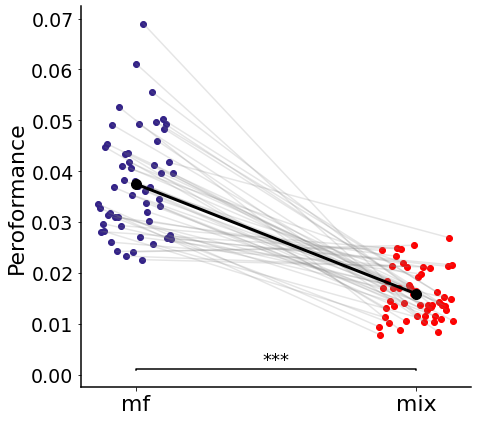

In [300]:
groups = ["mf", "mix"]
merged_df = merge_result_df([forward_avg, mix_sim], groups, 200, subjects)
# merged_df = merged_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
# merged_df = merged_df[merged_df["best_model"] == "mf"]
merged_df["performance"] = merged_df["performance"].pow(1/2)

color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
plt.title("paired test")
print("paired")
comparison_plot(
    merged_df,
    "performance",
    groups,
    "",
    [["mix", "mf"]],
    [.001, 1, 1.05],
    [.0001, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)

In [243]:
a = merged_df[merged_df["model"] == "emp"]["performance"].to_numpy() -  merged_df[merged_df["model"] == "mf"]["performance"].to_numpy()

a.argmax()

21

In [245]:
merged_df[merged_df["model"] == "emp"].iloc[21]

subject        46792
performance     0.91
model            emp
x_idx            239
best_model        mf
Name: 115, dtype: object

In [246]:
merged_df[merged_df["model"] == "mf"].iloc[21]

subject           46792
performance    0.741925
model                mf
x_idx                39
best_model           mf
Name: 114, dtype: object

non-paired test
Statistics for mf and emp =297.0, p=9.963e-13
Statistics for emp and mix =1697.0, p=1.428e-01
Statistics for mix and mf =2695.0, p=3.016e-14
mean mf = 0.76
mean emp = 0.86
mean mix = 0.85


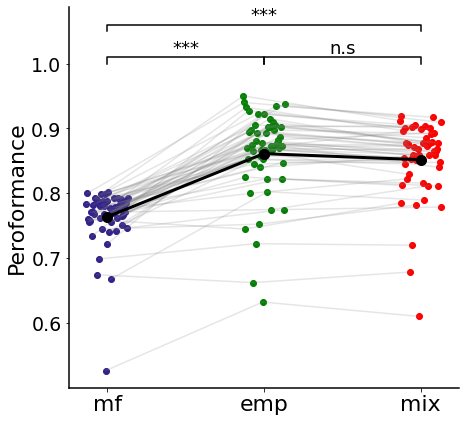

In [186]:
groups = ["mf", "emp", "mix"]
merged_df = merge_result_df([forward_avg, emp_avg, mix_sim], groups, 200, subjects)



color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
print("non-paired test")

comparison_plot(
    merged_df,
    "performance",
    groups,
    "",
    [["mf", "emp"], ["emp", "mix"], ["mix", "mf"]],
    [1, 1, 1.05],
    [.01, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)

In [93]:
emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performacne","sub":"subject"})


<AxesSubplot:xlabel='performance', ylabel='Count'>

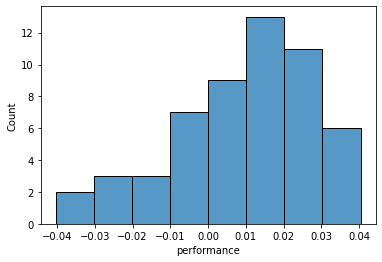

In [176]:

sns.histplot(emp_avg["performance"] - mix_sim["performance"])

In [185]:
color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                        var_df=pd.DataFrame(), color_dict = color_dict):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.mannwhitneyu(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

(p = 8.31e-08, r = -0.65,ci = [-0.78,-0.47])


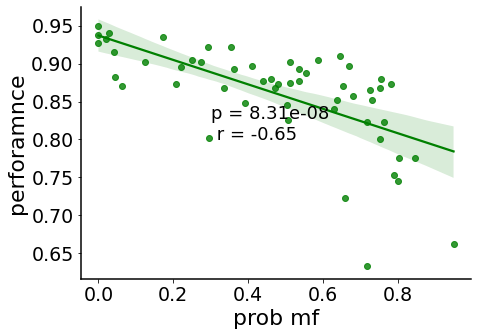

In [171]:
plt.figure(figsize=(7,5))
temp_df = emp_avg.merge(mix_df, on="subject")
temp_df2 = mix_sim.merge(mix_df, on="subject")
plot_regression_df(temp_df,"gamma", "performance", "green", .3, .8, "prob mf", "perforamnce")
# plot_regression_df(temp_df2,"gamma", "performance", "red", .3, .8, "prob mf", "perforamnce")

In [167]:
temp_df2

NameError: name 'temp_df2' is not defined